In [2]:
import numpy as np
import pandas as pd
# conda install py-xgboost
import xgboost as xgb
from plotnine import *
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Read Data and Data Engineering

In [3]:
data = pd.read_csv('Raw_material.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25369 entries, 0 to 25368
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Survey_Year             25369 non-null  int64 
 1   Expect_Children_Number  25369 non-null  int64 
 2   District                25369 non-null  object
 3   Province                25369 non-null  object
 4   Gender                  25369 non-null  object
 5   Born_Year               25369 non-null  int64 
 6   Age                     25369 non-null  int64 
 7   Nation                  25369 non-null  object
 8   Health                  25369 non-null  object
 9   Education               25340 non-null  object
 10  Marriage                25369 non-null  object
 11  Income                  25369 non-null  object
 12  Household_Size          25369 non-null  int64 
 13  Religion                25369 non-null  object
 14  Health_Insurance        25369 non-null  object
 15  Hu

## Data clean and Engineering

In [5]:
# target label
target = 'Expect_Children_Number'
# Remove attributes with too many missing values
data.drop(['House_Property', 'Working_Sector'], axis=1, inplace=True)
# Exclude the sample of women whose age is less than or equal to 20 or age is greater than or equal to 50
data.drop(data[(data['Gender'] == '女') & ((data['Age'] <= 20) | (data['Age'] >= 50))].index, inplace=True)

In [6]:
# 删除表中含有Nan的行
data.dropna(axis=0, how='any', inplace=True)

In [7]:
# 去除Expect_Children_Number >= 10的样本
data.drop(data[data[target] >= 10].index, inplace=True)

In [8]:
# District 中文 -> 数值
data.loc[data['District'] == '中', 'District'] = 2
data.loc[data['District'] == '东', 'District'] = 1
data.loc[data['District'] == '西', 'District'] = 3
data.loc[data['District'] == '东北', 'District'] = 0
data['District'] = data['District'].astype(int)
data['District'].describe()

count    16735.000000
mean         1.567553
std          0.976152
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          3.000000
Name: District, dtype: float64

In [9]:
# 去除Province
data.drop('Province', axis=1, inplace=True)

In [10]:
# Gender: 中文 -> 数值
data.loc[data['Gender'] == '男', 'Gender'] = 1
data.loc[data['Gender'] == '女', 'Gender'] = 0
data['Gender'] = data['Gender'].astype(int)
data['Gender'].describe()

count    16735.000000
mean         0.672543
std          0.469300
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Gender, dtype: float64

In [11]:
# 去除Born_Year列，但要先去除Survey_Year - Born_Year + 1 != Age的样本
data.drop(data[(data['Survey_Year'] - data['Born_Year'] + 1) != data['Age']].index, inplace=True)
data.drop('Born_Year', axis=1, inplace=True)

In [12]:
# Nation的 '回', '维', '蒙', '藏', '满', '壮', ‘其他’作为一类
# 中文 -> 数值
for nation in data['Nation'].unique():
    if nation == '汉':
        data.loc[data['Nation'] == nation, 'Nation'] = 0
    else:
        data.loc[data['Nation'] == nation, 'Nation'] = 1
data['Nation'] = data['Nation'].astype(int)
data['Nation'].describe()

count    16735.000000
mean         0.075411
std          0.264061
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Nation, dtype: float64

In [13]:
# 去除Health的“拒绝回答” “不知道”
data.drop(data[(data['Health'] == '不知道') | (data['Health'] == '拒绝回答')].index, inplace=True)
# Health 分级 从很不健康到很健康分为 5个等级 0, 1, 2, 3, 4
data.loc[data['Health'] == '很不健康', 'Health'] = 0
data.loc[data['Health'] == '比较不健康', 'Health'] = 1
data.loc[data['Health'] == '一般', 'Health'] = 2
data.loc[data['Health'] == '比较健康', 'Health'] = 3
data.loc[data['Health'] == '很健康', 'Health'] = 4
data['Health'] = data['Health'].astype(int)
data['Health'].describe()

count    16730.000000
mean         2.681351
std          1.039086
min          0.000000
25%          2.000000
50%          3.000000
75%          3.000000
max          4.000000
Name: Health, dtype: float64

In [14]:
# 去除Education 的 ‘其他’ '私塾'
data.drop(data[(data['Education'] == '其他') | (data['Education'] == '私塾、扫盲班')].index, inplace=True)
# 分为6类， 文盲，小学，初中，高中(中专， 技校，职业高中)，大学（大专），研究生
data.loc[data['Education'] == '没有受过任何教育', 'Education'] = 0
data.loc[data['Education'] == '小学', 'Education'] = 1
data.loc[data['Education'] == '初中', 'Education'] = 2
data.loc[(data['Education'] == '普通高中') | 
         (data['Education'] == '中专') |
         (data['Education'] == '职业高中') |
         (data['Education'] == '技校'), 'Education'] = 3
data.loc[(data['Education'] == '大学本科（正规高等教育）') |
         (data['Education'] == '大学专科（正规高等教育）') |
         (data['Education'] == '大学专科（成人高等教育）') |
         (data['Education'] == '大学本科（成人高等教育）'), 'Education'] = 4
data.loc[data['Education'] == '研究生及以上', 'Education'] = 5
data['Education'] = data['Education'].astype(int)
data['Education'].describe()

count    16647.000000
mean         2.389019
std          1.269205
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max          5.000000
Name: Education, dtype: float64

In [15]:
# Marriage 分类 初婚有配偶 再婚有配偶 未有配偶
data.loc[data['Marriage'] == '初婚有配偶', 'Marriage'] = 1
data.loc[data['Marriage'] == '再婚有配偶', 'Marriage'] = 2

data.loc[(data['Marriage'] == '未婚') | 
         (data['Marriage'] == '丧偶') |
         (data['Marriage'] == '离婚'), 'Marriage'] = 0
data.drop(data[(data['Marriage'] == '同居') | (data['Marriage'] == '分居未离婚')].index, inplace=True)
data['Marriage'] = data['Marriage'].astype(int)
data['Marriage'].describe()

count    16216.000000
mean         0.812099
std          0.434871
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: Marriage, dtype: float64

In [16]:
# 去除Income的“不知道”和”拒绝回答“
data.drop(data[(data['Income'] == '不知道') | (data['Income'] == '拒绝回答')].index, inplace=True)
# Income 分级 从远低于平均水平 到 远高于平均水平分级 0，1，2，3，4
data.loc[data['Income'] == '远低于平均水平', 'Income'] = 0
data.loc[data['Income'] == '低于平均水平', 'Income'] = 1
data.loc[data['Income'] == '平均水平', 'Income'] = 2
data.loc[data['Income'] == '高于平均水平', 'Income'] = 3
data.loc[data['Income'] == '远高于平均水平', 'Income'] = 4
data['Income'] = data['Income'].astype(int)
data['Income'].describe()

count    16097.000000
mean         1.602038
std          0.727745
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          4.000000
Name: Income, dtype: float64

In [17]:
# 去除Household_Size >= 10
data.drop(data[data['Household_Size'] >= 10].index, inplace=True)
data['Household_Size'].describe()

count    16053.000000
mean         2.928113
std          1.392440
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          9.000000
Name: Household_Size, dtype: float64

In [18]:
# 中文 -> 数值
data.loc[(data['Religion'] != '是') & (data['Religion'] != '不信仰宗教'), 'Religion'] = 0
data.loc[(data['Religion'] == '是') | (data['Religion'] == '不信仰宗教'), 'Religion'] = 1
data['Religion'] = data['Religion'].astype(int)
data['Religion'].describe()

count    16053.000000
mean         0.914346
std          0.279861
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Religion, dtype: float64

In [19]:
# 保留Health_Insurance的“参加”和“没有参加”
data.drop(data[(data['Health_Insurance'] != '参加') & (data['Health_Insurance'] != '没有参加')].index, inplace=True)
# 中文 -> 英文
data.loc[data['Health_Insurance'] == '参加', 'Health_Insurance'] = 1
data.loc[data['Health_Insurance'] == '没有参加', 'Health_Insurance'] = 0
data['Health_Insurance'] = data['Health_Insurance'].astype(int)
data['Health_Insurance'].describe()

count    15959.000000
mean         0.922614
std          0.267211
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Health_Insurance, dtype: float64

In [20]:
# 保留Hukou的“农业户口”和“非农业户口”,并将“居民户口”合并为非农业户口
data.loc[(data['Hukou'] == '居民户口（以前是非农业户口）') |
         (data['Hukou'] == '居民户口（以前是农业户口）'), 'Hukou'] = '非农业户口'
data.drop(data[(data['Hukou'] != '农业户口') & (data['Hukou'] != '非农业户口')].index, inplace=True)
# 中文 -> 英文
data.loc[data['Hukou'] == '农业户口', 'Hukou'] = 1
data.loc[data['Hukou'] == '非农业户口', 'Hukou'] = 0
data['Hukou'] = data['Hukou'].astype(int)
data['Hukou'].describe()

count    15909.000000
mean         0.546232
std          0.497874
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Hukou, dtype: float64

In [21]:
data[target].describe()

count    15909.000000
mean         1.954051
std          0.840401
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          8.000000
Name: Expect_Children_Number, dtype: float64

In [22]:
data['Age'].describe()

count    15909.000000
mean        47.066629
std         16.074790
min         19.000000
25%         34.000000
50%         45.000000
75%         59.000000
max        104.000000
Name: Age, dtype: float64

In [23]:
# target label
data.loc[data[target] <= 1, target] = 0
data.loc[data[target] >= 2, target] = 1

In [24]:
# 去除Survey_Year 并产生2017全体样本 和 2018全体样本
data_2017 = data[data['Survey_Year'] == 2017]
data_2018 = data[data['Survey_Year'] == 2018]
data.drop('Survey_Year', axis=1, inplace=True)

In [25]:
cols = list(data.columns)
classify_cols = cols[1:]

In [26]:
classify_cols

['District',
 'Gender',
 'Age',
 'Nation',
 'Health',
 'Education',
 'Marriage',
 'Income',
 'Household_Size',
 'Religion',
 'Health_Insurance',
 'Hukou']

In [27]:
data.columns

Index(['Expect_Children_Number', 'District', 'Gender', 'Age', 'Nation',
       'Health', 'Education', 'Marriage', 'Income', 'Household_Size',
       'Religion', 'Health_Insurance', 'Hukou'],
      dtype='object')

## 训练集测试集划分

In [28]:
X_neg = data[data[target] == 0]
X_pos = data[data[target] == 1].sample(len(X_neg))
new_data = pd.concat([X_neg, X_pos])
new_data = shuffle(new_data)

In [29]:
X = new_data.drop(target, axis=1)
y = new_data[target]
# 数据归一化
X_ = preprocessing.scale(X)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.3, shuffle=True, random_state=42)

## B-P neural network

In [31]:
bp = MLPClassifier(hidden_layer_sizes=(4,), activation='relu',
                   solver='adam', alpha=0.0001, batch_size='auto',
                   learning_rate='adaptive', max_iter=10000)

In [32]:
bp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(4,), learning_rate='adaptive', max_iter=10000)

In [33]:
bp.score(X_test, y_test)

0.6444135373203523

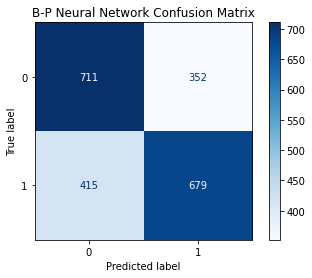

In [34]:
disp = plot_confusion_matrix(bp, X_test, y_test, cmap=plt.cm.Blues)  # 混淆矩阵
disp.ax_.set_title('B-P Neural Network Confusion Matrix')
plt.show()

## Random Forest

In [35]:
n_estimators = [i for i in range(1, 515, 15)]
err = []
for n_estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=n_estimator)
    rf.fit(X_train, y_train)
    err.append(1 - rf.score(X_test, y_test))

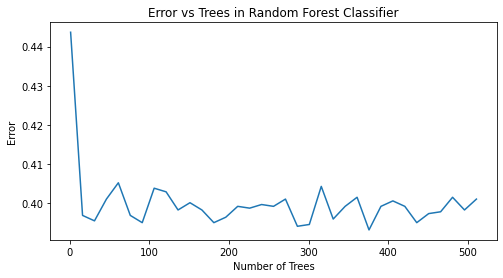

In [36]:
plt.figure(figsize=(8, 4))
plt.title('Error vs Trees in Random Forest Classifier')
plt.plot(n_estimators, err)
plt.ylabel('Error'), plt.xlabel('Number of Trees')
plt.show()

In [40]:
# 选择最优的n_estimators
index = err.index(min(err))
rf_best = RandomForestClassifier(n_estimators=n_estimators[index])
rf_best.fit(X_train, y_train)

RandomForestClassifier(n_estimators=376)

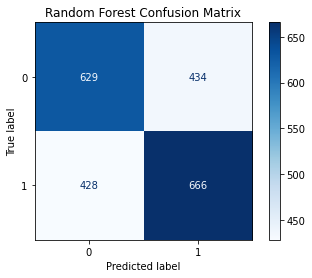

In [41]:
disp = plot_confusion_matrix(rf_best, X_test, y_test, cmap=plt.cm.Blues)  # 混淆矩阵
disp.ax_.set_title('Random Forest Confusion Matrix')
plt.show()

In [42]:
# 重要因素排名 前10
importances = rf_best.feature_importances_
indices = np.argsort(importances)[::-1]
df = {'Attrs': [], 'Importance': []}
for i in range(10):
    df['Attrs'].append(X.columns[indices[i]])
    df['Importance'].append(importances[indices[i]])

In [43]:
rank = pd.DataFrame(df)
rank

,Attrs,Importance
0,Age,0.348856
1,Household_Size,0.112856
2,Health,0.105191
3,Education,0.098838
4,District,0.097088
5,Income,0.087151
6,Marriage,0.032206
7,Hukou,0.032030
8,Gender,0.029052
9,Health_Insurance,0.020847


## XG-Boost

In [44]:
clf = xgb.XGBClassifier()

In [45]:
clf.fit(X_train, y_train, eval_metric='logloss')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [46]:
clf.score(X_test, y_test)

0.6332869726471951

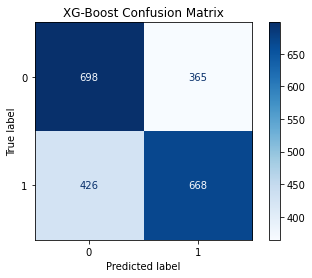

In [47]:
disp = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)  # 混淆矩阵
disp.ax_.set_title('XG-Boost Confusion Matrix')
plt.show()

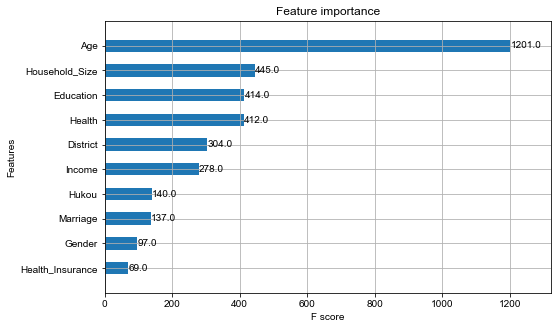

In [48]:
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # MacOS 显示中文
fig, ax = plt.subplots(figsize=(8, 5))
clf.get_booster().feature_names = list(X.columns)
xgb.plot_importance(clf.get_booster(), ax=ax, height=0.5, grid=True, max_num_features=10)
plt.show()

### ROC

In [49]:
color = ["#3a5e8cFF", "#10a53dFF", "#541352FF", "#ffcf20FF", "#2f9aa0FF"]
def seq(start, stop, by, round_n=3):
    return [round(x, round_n) for x in list(np.arange(start, stop, by))]

In [50]:
predicted_probabilities = clf.predict_proba(X_test)[:,1]

In [51]:
# discrete ROC (with thresholds in steps) on test data -------------------------------------------------
thresholds = seq(0, 1, by = 0.01)
cm = dict()
true_positive_rates = []
false_positive_rates = []
prediction = []
for thr in thresholds:
    prediction = np.where(predicted_probabilities < thr, 0, 1)
    cm_thr = confusion_matrix(y_test, prediction, labels=[0, 1])
    cm[thr] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    true_positive_rates.append(tp/(tp+fn))
    false_positive_rates.append(fp/(fp+tn))

In [52]:
tpr_fpr_for_thresholds = pd.DataFrame(
    {'thresholds': thresholds,
     'true_positive_rates': true_positive_rates,
     'false_positive_rates': false_positive_rates})

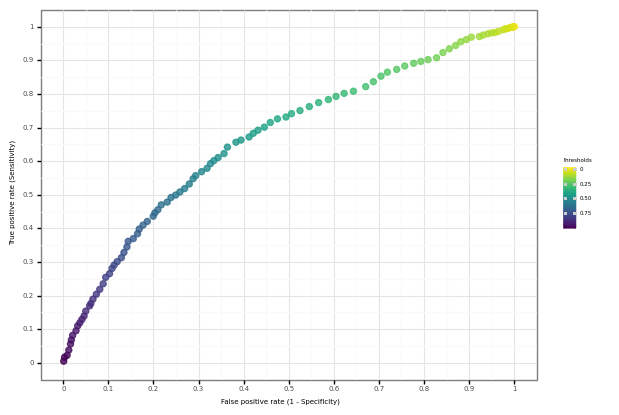

<ggplot: (8777262714321)>

In [53]:
ggplot(tpr_fpr_for_thresholds, aes(x = 'false_positive_rates', y = 'true_positive_rates', color='thresholds'))\
        + labs(x = "False positive rate (1 - Specificity)", y = "True positive rate (Sensitivity)")\
        + geom_point(size=2, alpha=0.8) + scale_color_continuous(trans = 'reverse')\
        + scale_x_continuous(limits=(0,1), breaks = seq(0, 1.01, by = 0.1))\
        + scale_y_continuous(limits=(0,1), breaks = seq(0, 1.01, by = 0.1))\
        + theme_bw()\
        +theme(legend_position="right",
            axis_text=element_text(size=5),
            axis_title=element_text(size=5),
            legend_text = element_text(size = 4),
            legend_title = element_text(size = 4),
            legend_key_size=6)

In [54]:
def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    })
    
    plot = ggplot(all_coords, aes(x = 'fpr', y = 'tpr')) \
        + geom_line(color=color[0], size = 0.7) \
        + geom_area(position = 'identity', fill = 'mediumaquamarine', alpha = 0.3) \
        + xlab("False Positive Rate (1-Specifity)") \
        + ylab("True Positive Rate (Sensitivity)") \
        + geom_abline(intercept = 0, slope = 1,  linetype = "dotted", color = "black") \
        + scale_y_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0, 0.01)) \
        + scale_x_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0.01, 0)) \
        + theme_bw()
    return(plot)

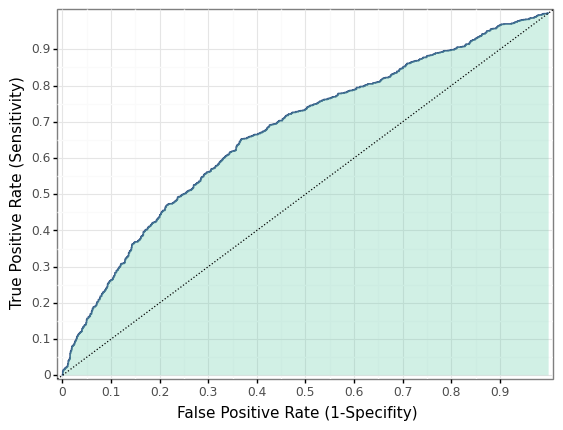

<ggplot: (8777334716225)>

In [55]:
create_roc_plot(y_test, predicted_probabilities)

## Model Compare

In [56]:
com = {'B-P Neural Network': [precision_score(y_test, bp.predict(X_test)), recall_score(y_test, bp.predict(X_test))],
       'Random Forest': [precision_score(y_test, rf_best.predict(X_test)), recall_score(y_test, rf_best.predict(X_test))],
       'XG-Boost': [precision_score(y_test, clf.predict(X_test)), recall_score(y_test, clf.predict(X_test))]}

In [57]:
compare = pd.DataFrame(com, index=['Precision', 'Recall'])
compare

,B-P Neural Network,Random Forest,XG-Boost
Precision,0.658584,0.605455,0.646660
Recall,0.620658,0.608775,0.610603


## Overall Logit

In [58]:
import statsmodels.api as sm

In [59]:
results = sm.OLS(y, X).fit()

In [60]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     Expect_Children_Number   R-squared (uncentered):                   0.551
Model:                                OLS   Adj. R-squared (uncentered):              0.550
Method:                     Least Squares   F-statistic:                              734.0
Date:                    Thu, 27 Jan 2022   Prob (F-statistic):                        0.00
Time:                            16:14:54   Log-Likelihood:                         -4831.7
No. Observations:                    7190   AIC:                                      9687.
Df Residuals:                        7178   BIC:                                      9770.
Df Model:                              12                                                  
Covariance Type:                nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
District             0.0847      0.006     14.233      0.000       0.073       0.096
Gender               0.0165      0.013      1.246      0.213      -0.009       0.042
Age                  0.0050      0.000     12.635      0.000       0.004       0.006
Nation               0.0026      0.023      0.113      0.910      -0.042       0.047
Health               0.0003      0.006      0.046      0.963      -0.011       0.011
Education           -0.0142      0.005     -2.735      0.006      -0.024      -0.004
Marriage             0.0251      0.014      1.839      0.066      -0.002       0.052
Income               0.0316      0.008      3.895      0.000       0.016       0.047
Household_Size       0.0297      0.004      6.786      0.000       0.021       0.038
Religion            -0.0791      0.020     -4.057      0.000      -0.117      -0.041
Health_Insurance     0.0297      0.020      1.498      0.134      -0.009       0.069
Hukou                0.1219      0.012      9.808      0.000       0.098       0.146
==============================================================================
Omnibus:                    35839.023   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              768.446
Skew:                           0.026   Prob(JB):                    1.36e-167
Kurtosis:                       1.399   Cond. No.                         206.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Male and Female Logit

In [61]:
female = new_data[new_data['Gender'] == 0]
X_female = female.drop([target, 'Gender'], axis=1)
y_female = female[target]

In [62]:
female_res = sm.OLS(y_female, X_female).fit()
female_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     Expect_Children_Number   R-squared (uncentered):                   0.501
Model:                                OLS   Adj. R-squared (uncentered):              0.499
Method:                     Least Squares   F-statistic:                              224.8
Date:                    Thu, 27 Jan 2022   Prob (F-statistic):                        0.00
Time:                            16:14:55   Log-Likelihood:                         -1664.2
No. Observations:                    2473   AIC:                                      3350.
Df Residuals:                        2462   BIC:                                      3414.
Df Model:                              11                                                  
Covariance Type:                nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
District             0.0893      0.010      8.741      0.000       0.069       0.109
Age                  0.0056      0.001      5.434      0.000       0.004       0.008
Nation               0.0191      0.038      0.505      0.613      -0.055       0.093
Health               0.0010      0.010      0.096      0.924      -0.019       0.021
Education           -0.0263      0.009     -3.003      0.003      -0.044      -0.009
Marriage             0.0018      0.026      0.069      0.945      -0.049       0.052
Income               0.0221      0.014      1.552      0.121      -0.006       0.050
Household_Size       0.0372      0.008      4.944      0.000       0.022       0.052
Religion            -0.0598      0.032     -1.842      0.066      -0.123       0.004
Health_Insurance     0.0427      0.033      1.305      0.192      -0.021       0.107
Hukou                0.0873      0.021      4.084      0.000       0.045       0.129
==============================================================================
Omnibus:                    13130.479   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              275.236
Skew:                           0.198   Prob(JB):                     1.71e-60
Kurtosis:                       1.414   Cond. No.                         158.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
male = new_data[new_data['Gender'] == 1]
X_male = male.drop([target, 'Gender'], axis=1)
y_male = male[target]

In [64]:
male_res = sm.OLS(y_male, X_male).fit()
male_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     Expect_Children_Number   R-squared (uncentered):                   0.574
Model:                                OLS   Adj. R-squared (uncentered):              0.573
Method:                     Least Squares   F-statistic:                              577.1
Date:                    Thu, 27 Jan 2022   Prob (F-statistic):                        0.00
Time:                            16:14:56   Log-Likelihood:                         -3162.9
No. Observations:                    4717   AIC:                                      6348.
Df Residuals:                        4706   BIC:                                      6419.
Df Model:                              11                                                  
Covariance Type:                nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
District             0.0823      0.007     11.227      0.000       0.068       0.097
Age                  0.0051      0.000     12.452      0.000       0.004       0.006
Nation              -0.0080      0.028     -0.282      0.778      -0.064       0.048
Health               0.0003      0.007      0.045      0.964      -0.013       0.014
Education           -0.0068      0.007     -1.043      0.297      -0.020       0.006
Marriage             0.0321      0.017      1.943      0.052      -0.000       0.064
Income               0.0370      0.010      3.741      0.000       0.018       0.056
Household_Size       0.0263      0.005      4.868      0.000       0.016       0.037
Religion            -0.0873      0.025     -3.539      0.000      -0.136      -0.039
Health_Insurance     0.0215      0.025      0.850      0.395      -0.028       0.071
Hukou                0.1429      0.015      9.317      0.000       0.113       0.173
==============================================================================
Omnibus:                    23723.391   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              507.281
Skew:                          -0.064   Prob(JB):                    7.00e-111
Kurtosis:                       1.399   Cond. No.                         229.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 2017 Logit

In [65]:
X_2017 = data_2017.drop([target, 'Survey_Year'], axis=1)
y_2017 = data_2017[target]

In [66]:
res_2017 = sm.OLS(y_2017, X_2017).fit()
res_2017.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     Expect_Children_Number   R-squared (uncentered):                   0.793
Model:                                OLS   Adj. R-squared (uncentered):              0.793
Method:                     Least Squares   F-statistic:                              2550.
Date:                    Thu, 27 Jan 2022   Prob (F-statistic):                        0.00
Time:                            16:14:57   Log-Likelihood:                         -4059.9
No. Observations:                    7998   AIC:                                      8144.
Df Residuals:                        7986   BIC:                                      8228.
Df Model:                              12                                                  
Covariance Type:                nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
District             0.0699      0.005     14.504      0.000       0.060       0.079
Gender              -0.0014      0.011     -0.134      0.894      -0.023       0.020
Age                  0.0061      0.000     19.175      0.000       0.005       0.007
Nation               0.0055      0.017      0.313      0.755      -0.029       0.040
Health               0.0215      0.004      4.805      0.000       0.013       0.030
Education            0.0205      0.004      4.698      0.000       0.012       0.029
Marriage             0.0274      0.011      2.439      0.015       0.005       0.049
Income               0.0252      0.006      3.897      0.000       0.013       0.038
Household_Size       0.0293      0.003      8.709      0.000       0.023       0.036
Religion            -0.0064      0.015     -0.415      0.678      -0.037       0.024
Health_Insurance     0.0732      0.016      4.450      0.000       0.041       0.105
Hukou                0.1200      0.010     11.742      0.000       0.100       0.140
==============================================================================
Omnibus:                     1152.144   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1726.187
Skew:                          -1.135   Prob(JB):                         0.00
Kurtosis:                       2.842   Cond. No.                         203.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 2018 Logit

In [67]:
X_2018 = data_2018.drop([target, 'Survey_Year'], axis=1)
y_2018 = data_2018[target]

In [68]:
res_2018 = sm.OLS(y_2018, X_2018).fit()
res_2018.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     Expect_Children_Number   R-squared (uncentered):                   0.781
Model:                                OLS   Adj. R-squared (uncentered):              0.781
Method:                     Least Squares   F-statistic:                              2350.
Date:                    Thu, 27 Jan 2022   Prob (F-statistic):                        0.00
Time:                            16:14:58   Log-Likelihood:                         -4166.1
No. Observations:                    7911   AIC:                                      8356.
Df Residuals:                        7899   BIC:                                      8440.
Df Model:                              12                                                  
Covariance Type:                nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
District             0.0611      0.005     12.308      0.000       0.051       0.071
Gender               0.0256      0.011      2.290      0.022       0.004       0.048
Age                  0.0050      0.000     15.504      0.000       0.004       0.006
Nation               0.0135      0.019      0.729      0.466      -0.023       0.050
Health               0.0160      0.005      3.480      0.001       0.007       0.025
Education            0.0039      0.004      0.933      0.351      -0.004       0.012
Marriage             0.0309      0.012      2.649      0.008       0.008       0.054
Income               0.0438      0.007      6.460      0.000       0.031       0.057
Household_Size       0.0352      0.003     10.213      0.000       0.028       0.042
Religion             0.0326      0.016      2.054      0.040       0.001       0.064
Health_Insurance     0.0721      0.016      4.411      0.000       0.040       0.104
Hukou                0.1182      0.010     11.666      0.000       0.098       0.138
==============================================================================
Omnibus:                     1084.698   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1525.174
Skew:                          -1.061   Prob(JB):                         0.00
Kurtosis:                       2.649   Cond. No.                         215.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""